In [1]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Libaries')

In [31]:
# Importing self-made libaries
import sensitivity as st
import Monte_Carlo as mc
import reload_lib as rl
import life_cycle_assessment as lc
import sens_table as tab


lib = [st, mc, lc, tab]

In [5]:
# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care'
# Specifying the LCIA method
lcia_method = 'recipe'

ecoinevnt_paths = {'ev391apos' : r"C:\Users\ruw\Desktop\4. semester\EcoInvent\ecoinvent 3.9.1_apos_ecoSpold02\datasets",
                   'ev391consq' : r"C:\Users\ruw\Desktop\4. semester\EcoInvent\ecoinvent 3.9.1_consequential_ecoSpold02\datasets",
                   'ev391cutoff' : r"C:\Users\ruw\Downloads\ecoinvent 3.9.1_cutoff_ecoSpold02\datasets"}
system_path = [r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Data\databases\case1.xlsx', 
                r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Data\databases\case2.xlsx']

rl.reload_lib(lib)

In [15]:
rl.reload_lib(lib)
variables = st.break_even_initialization(path, lcia_method, lib, ecoinevnt_paths, system_path)


Biosphere is already present in the project.
Ecoinvent 3.9.1 is already present in the project.
False
You selected to not reload
case1_apos already exist
Chosen flows:
H200 REC
H200 SU
H400 REC
H400 SU
alubox (large + dishwasher)
alubox (large + wipe)
alubox (small + dishwasher)
alubox (small + wipe)
Recipe is selected


In [310]:
rl.reload_lib(lib)
df_sensitivity = tab.uncertainty_values_new(variables)
df_sensitivity


,H2S - lower%,H2S - upper%,H2R - lower%,H2R - upper%,ASC - lower%,ASC - upper%,ASW - lower%,ASW - upper%,H4S - lower%,H4S - upper%,H4R - lower%,H4R - upper%,ALC - lower%,ALC - upper%,ALW - lower%,ALW - upper%
Life time,-,-,-,-,-38.79%,61.21%,-38.79%,61.21%,-,-,-,-,-38.79%,61.21%,-38.79%,61.21%
autoclave,-,50.00%,-,50.00%,-,33.33%,-,33.33%,-,12.50%,-,12.50%,-,50.00%,-,50.00%
protection cover,-11.27%,-,-11.27%,-,-,-,-,-,-5.94%,-,-5.94%,-,-,-,-,-
total,-11.27%,50.00%,-11.27%,50.00%,-38.79%,94.54%,-38.79%,94.54%,-5.94%,12.50%,-5.94%,12.50%,-38.79%,111.21%,-38.79%,111.21%


<class 'dict'>


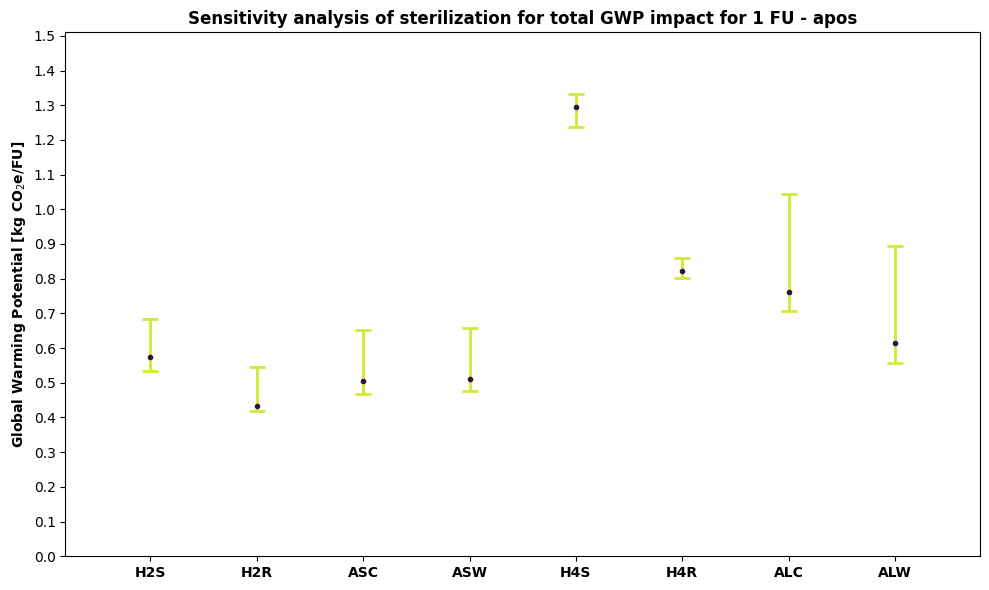

In [309]:
y_min = 0
y_max = 1.5
y_step = 1/10
y_offset = 0.01
rl.reload_lib(lib)
y_axis = [y_min, y_max, y_step, y_offset]
    
df_tot_err, df_err_min, df_err_max = st.uncertainty_graph(variables, lib, y_axis)
